In [1]:
import math

import re

import time

from google.colab import drive

import warnings

warnings.filterwarnings('ignore')

In [2]:
try :

    %tensorflow_version 2.x

except :

    pass
    
import tensorflow as tf

from tensorflow.keras import layers

import tensorflow_datasets as tfds

In [3]:
import pandas as pd

import numpy as np

import h5py

from gensim.models import Word2Vec

import gensim.models

from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Embedding

from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation

from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import SimpleRNN

from tensorflow.keras.layers import GRU

from tensorflow.keras.preprocessing.sequence import pad_sequences 

import re

from nltk.tokenize import word_tokenize

import nltk

nltk.download('punkt')

from nltk.corpus import stopwords 

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_clickbait = pd . read_csv ('/content/drive/My Drive/clickbait_data' , sep = ' \ n ' , header = None )

data_noclickbait = pd . read_csv ('/content/drive/My Drive/non_clickbait_data' , sep = ' \ n ' , header = None )

data_clickbait = data_clickbait.sample(frac = 7.5/16)

data_noclickbait = data_noclickbait.sample(frac = 7.5/16)

data_clickbait['class'] = [1 for i in range(7500)]

data_noclickbait['class'] = [0 for i in range(7500)] 

data_Final = pd . concat (( data_clickbait , data_noclickbait ), ignore_index = True ) 

df = data_Final . rename ( columns = { 0 : "text" })

df = df . sample ( frac = 1 ). reset_index ( drop = True )

print(df.shape)

print(df.head(5))

(15000, 2)
                                                text  class
0  Can You Guess These Drake Songs By The Emoji S...      1
1  Fortieth anniversary of first manned Moon landing      0
2  15 Times Donald Trump Was Anyone Who's Ever Th...      1
3  Women Should Not Give Haircuts To Their BFFs.....      1
4  What Your Star Sign Actually Says About You, A...      1


In [6]:
df

,text,class
0,Can You Guess These Drake Songs By The Emoji S...,1
1,Fortieth anniversary of first manned Moon landing,0
2,15 Times Donald Trump Was Anyone Who's Ever Th...,1
3,Women Should Not Give Haircuts To Their BFFs.....,1
4,"What Your Star Sign Actually Says About You, A...",1
...,...,...
14995,A Dad Helped His Son With Cerebral Palsy Shred...,1
14996,23 Awesome Gifts To Help Your Stoner Best Frie...,1
14997,"Which ""American Horror Story: Hotel"" Character...",1
14998,England and Wales Director of Public Prosecuti...,0


In [7]:
stop_words  =  set ( stopwords . words ( 'english' ))

In [8]:
from sklearn.model_selection import train_test_split

L = []
for  i , token  in  enumerate ( df [ 'text' ]):
    words = [ w  for  w  in  token . split ()]
    L . append ( len ( words ))
    
sequence_size = max ( L )


X = df['text']

y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [9]:
y_train = np.array(y_train)

y_test = np.array(y_test)

y_val = np.array(y_val)

In [10]:
WORD2VEC_VECTORS_BIN  = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'

w2v  =  gensim.models.KeyedVectors.load_word2vec_format(WORD2VEC_VECTORS_BIN , binary = True )

In [11]:
train_data=np.zeros((len(X_train), sequence_size, 300))

val_data=np.zeros((len(X_val), sequence_size, 300))

test_data = np.zeros((len(X_test), sequence_size, 300))

for i,sentence in enumerate(X_train) :

  sentence = sentence.replace('-', ' ')

  words = nltk.word_tokenize(sentence)

  j = 0 

  for  w  in  words :

    try :
        
      train_data [ i , j ] = w2v [ w ]

      j += 1

    except :
        
      pass

for i,sentence in enumerate(X_val) :

  sentence = sentence.replace('-',' ')

  words = nltk.word_tokenize(sentence)

  j = 0
  
  for  w  in  words :

    try :
        
      val_data [ i , j ] = w2v [ w ]

      j += 1

    except :
        
      pass
        

for i,sentence in enumerate(X_test) :

  sentence = sentence.replace('-',' ')

  words = nltk.word_tokenize(sentence)

  j = 0
  
  for  w  in  words :

    try :
        
      test_data [ i , j ] = w2v [ w ]

      j += 1

    except :
        
      pass
  
print (test_data.shape)
print (train_data.shape)
print (val_data.shape)

(3000, 21, 300)
(9000, 21, 300)
(3000, 21, 300)


In [12]:
class PositionalEncoding(layers.Layer):
  
    def __init__(self) :

        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model) :

        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))

        return pos * angles

    def call(self, inputs) :

        seq_length = inputs.shape.as_list()[-2]

        d_model = inputs.shape.as_list()[-1]

        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)

        angles[:, 0::2] = np.sin(angles[:, 0::2])

        angles[:, 1::2] = np.cos(angles[:, 1::2])
        
        pos_encoding = angles[np.newaxis, ...]

        return inputs + tf.cast(pos_encoding, tf.float32)

In [13]:
def scaled_dot_product_attention(queries, keys, values, mask) :
  
    product = tf.matmul(queries, keys, transpose_b  = True)
    
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)

    scaled_product = product / tf.math.sqrt(keys_dim)
    
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis = -1), values)
    
    return attention

In [14]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, nb_proj) :

        super(MultiHeadAttention, self).__init__()

        self.nb_proj = nb_proj
        
    def build(self, input_shape) :

        self.d_model = input_shape[-1]

        assert self.d_model % self.nb_proj == 0
        
        self.d_proj = self.d_model // self.nb_proj
        
        self.query_lin = layers.Dense(units=self.d_model)

        self.key_lin = layers.Dense(units=self.d_model)

        self.value_lin = layers.Dense(units=self.d_model)
        
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)

        shape = (batch_size,-1, self.nb_proj,self.d_proj)

        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)

        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask) :

        batch_size = tf.shape(queries)[0]
        
        queries = self.query_lin(queries)

        keys = self.key_lin(keys)

        values = self.value_lin(values)
        
        queries = self.split_proj(queries, batch_size)

        keys = self.split_proj(keys, batch_size)

        values = self.split_proj(values, batch_size)
        
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attention,shape=(batch_size, -1, self.d_model))
        
        outputs = self.final_lin(concat_attention)
        
        return outputs

In [15]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate) :

        super(EncoderLayer, self).__init__()

        self.FFN_units = FFN_units

        self.nb_proj = nb_proj

        self.dropout_rate = dropout_rate
    
    def build(self, input_shape) :

        self.d_model = input_shape[-1]
        
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)

        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)

        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")

        self.dense_2 = layers.Dense(units=self.d_model)

        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)

        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training) :

        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        
        attention = self.dropout_1(attention, training=training)

        attention = self.norm_1(attention + inputs)
        
        outputs = self.dense_1(attention)

        outputs = self.dense_2(outputs)

        outputs = self.dropout_2(outputs, training=training)
        
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [16]:
class Encoder(layers.Layer) :
    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 d_model,
                 name="encoder") :

        super(Encoder, self).__init__(name=name)

        self.nb_layers = nb_layers

        self.d_model = d_model
        
        self.pos_encoding = PositionalEncoding()

        self.dropout = layers.Dropout(rate=dropout_rate)

        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training) :


        inputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        outputs = self.pos_encoding(inputs)

        outputs = self.dropout(outputs, training)
        
        for i in range(self.nb_layers) :
          
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

In [17]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               d_model)
        # self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq):
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, training = True):
        enc_mask = self.create_padding_mask(enc_inputs)
        
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        
        return enc_outputs

In [18]:
D_MODEL = 300

NB_LAYERS = 2

FFN_UNITS = 512

NB_PROJ = 4

DROPOUT_RATE = 0.1

transformer = Transformer(d_model = D_MODEL,
                          nb_layers = NB_LAYERS,
                          FFN_units = FFN_UNITS,
                          nb_proj = NB_PROJ,
                          dropout_rate = DROPOUT_RATE)


inputs = layers.Input(shape = (sequence_size,D_MODEL))

x = transformer(inputs)

x = layers.Flatten()(x)

x = layers.Dense(512, activation="relu")(x)

x = layers.Dropout(0.1)(x)

x = layers.Dense(256, activation="relu")(x)

x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.summary()

model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21, 300)]         0         
_________________________________________________________________
transformer (Transformer)    (None, 21, 300)           1340824   
_________________________________________________________________
flatten (Flatten)            (None, 6300)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3226112   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0     

In [19]:
history = model.fit(train_data , y_train  , batch_size = 64 , epochs = 20 , validation_data = (val_data , y_val), verbose = 1)

Epoch 1/20
141/141 [==============================] - 6s 39ms/step - loss: 0.2403 - accuracy: 0.9363 - val_loss: 0.0858 - val_accuracy: 0.9773
Epoch 2/20
141/141 [==============================] - 5s 33ms/step - loss: 0.0670 - accuracy: 0.9788 - val_loss: 0.0815 - val_accuracy: 0.9743
Epoch 3/20
141/141 [==============================] - 5s 34ms/step - loss: 0.0549 - accuracy: 0.9813 - val_loss: 0.0524 - val_accuracy: 0.9823
Epoch 4/20
141/141 [==============================] - 5s 33ms/step - loss: 0.0401 - accuracy: 0.9884 - val_loss: 0.0480 - val_accuracy: 0.9850
Epoch 5/20
141/141 [==============================] - 5s 33ms/step - loss: 0.0351 - accuracy: 0.9882 - val_loss: 0.0585 - val_accuracy: 0.9807
Epoch 6/20
141/141 [==============================] - 5s 33ms/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0.0702 - val_accuracy: 0.9843
Epoch 7/20
141/141 [==============================] - 5s 34ms/step - loss: 0.0286 - accuracy: 0.9908 - val_loss: 0.0715 - val_accuracy: 0.9800

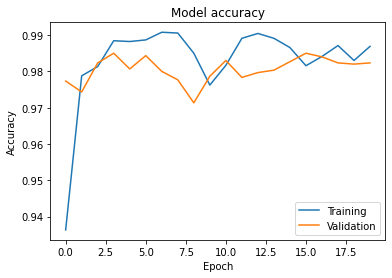

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

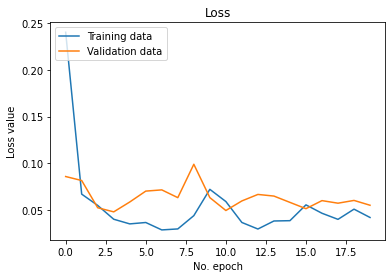

In [21]:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [22]:
y_pred = model.predict(test_data)

In [23]:
y_pred

array([[9.9659544e-01],
       [2.9296199e-08],
       [9.9383104e-01],
       ...,
       [6.7317659e-01],
       [9.9751079e-01],
       [1.0422402e-07]], dtype=float32)

In [24]:
score , acc  =  model.evaluate(test_data , y_test , batch_size = 64)

47/47 [==============================] - 1s 14ms/step - loss: 0.0519 - accuracy: 0.9830


In [25]:
print(' Test Score : ' , score)

 Test Score :  0.051935724914073944


In [26]:
print('Test Accuracy : ', acc)

Test Accuracy :  0.9829999804496765


In [27]:
def predict_function(y_pred) :

  for i in range(y_pred.shape[0]) :

    if y_pred[i][0] >= 0.5 :

      y_pred[i][0] = 1

    else :

      y_pred[i][0] = 0

  return y_pred.astype('int64')

In [28]:
y_pred = predict_function(y_pred)

In [29]:
y_test = y_test.reshape(-1,1)

In [30]:
metrics  =  classification_report(y_test , y_pred , digits = 4)

print('Classification Report ')

print("\n")

print(metrics)

cm  =  confusion_matrix (y_test,y_pred)

print('Confusion Matrix')

print("\n")

print(cm)

Classification Report 


              precision    recall  f1-score   support

           0     0.9840    0.9820    0.9830      1501
           1     0.9820    0.9840    0.9830      1499

    accuracy                         0.9830      3000
   macro avg     0.9830    0.9830    0.9830      3000
weighted avg     0.9830    0.9830    0.9830      3000

Confusion Matrix


[[1474   27]
 [  24 1475]]


In [42]:
def TestingOwnData(sentence) :
  
  X = np.zeros((1,sequence_size,300))

  sentence = sentence.replace('-',' ')

  words = nltk.word_tokenize(sentence)

  j = 0

  for  w  in  words :

      try :
          
        X[0,j] = w2v[w]

        j += 1

      except :
          
        pass

  if predict_function(model.predict(X))[0][0] == 1 :
                      
      return 'Clickbait'

  return 'Non Clickbait'

In [43]:
TestingOwnData('Amazing Inventions You Won’t Believe Exist')

'Clickbait'

In [44]:
TestingOwnData('Tamil Nadu reports 4,280 fresh COVID-19 cases and 65 deaths')

'Non Clickbait'

In [45]:
TestingOwnData('Can Face Masks Prevent You From Getting the Coronavirus? Doctors Weight In')

'Clickbait'

In [46]:
TestingOwnData('PM Modi asks to prepare Digital booklets documenting the relief works')

'Non Clickbait'

In [47]:
TestingOwnData('No passenger flights to Kolkata from Delhi, Mumbai, Chennai and 3 other cities between Jul 6-19')

'Non Clickbait'